# Pytorch Food101 Dataset Nueral Network

In [1]:
# full_food101_pytorch.py
import os
import json
import time
import math
from pathlib import Path

import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm

import tensorflow as tf
import tensorflow_datasets as tfds
from PIL import Image

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
import torchvision.transforms as transforms
import torch.backends.cudnn as cudnn

Configuration

In [2]:
IMG_SIZE = 112
BATCH_SIZE = 16
EPOCHS = 10
LEARNING_RATE = 1e-3
WEIGHT_DECAY = 1e-4
GRAD_CLIP = 1.0           # gradient clipping norm
PATIENCE = 8              # early stopping patience
NUM_WORKERS = 2
SAVE_DIR = Path("checkpoints")
SAVE_DIR.mkdir(parents=True, exist_ok=True)
BEST_MODEL_PATH = SAVE_DIR / "best_food101_model.pth"
HISTORY_PATH = SAVE_DIR / "history.json"
MAX_TRAIN_SAMPLES = 10000
MAX_VAL_SAMPLES   = 2000

# randomness for reproducibility
SEED = 42
torch.manual_seed(SEED)
np.random.seed(SEED)
cudnn.deterministic = True
cudnn.benchmark = True

checking for device

In [3]:
device = torch.device("cuda" if torch.cuda.is_available()
                      else "mps" if (hasattr(torch.backends, 'mps') and torch.backends.mps.is_available())
                      else "cpu")
print("Using device:", device)

Using device: cuda


downloading dataset through tfs

In [4]:
(train_ds_tf, val_ds_tf), ds_info = tfds.load(
    'food101',
    split=['train', 'validation'],
    shuffle_files=False,
    as_supervised=True,
    with_info=True
)

num_classes = ds_info.features['label'].num_classes
num_train_examples = ds_info.splits['train'].num_examples
num_val_examples = ds_info.splits['validation'].num_examples
print(f"Dataset info: {num_train_examples} train, {num_val_examples} val, {num_classes} classes")

Dataset info: 75750 train, 25250 val, 101 classes


Wrapping Pytorch Dataset

In [5]:
from torch.utils.data import Dataset, DataLoader
from PIL import Image
import torchvision.transforms as transforms
import torch

class Food101Dataset(Dataset):
    def __init__(self, tfds_dataset, transform=None, max_samples=None):
        self.transform = transform

        self.images = []
        self.labels = []

        for i, (image, label) in enumerate(tfds_dataset.as_numpy_iterator()):
            if max_samples and i >= max_samples:
                break
            self.images.append(image)
            self.labels.append(label)

        print(f"Cached {len(self.images)} samples")

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        image = Image.fromarray(self.images[idx])
        if self.transform:
            image = self.transform(image)
        label = torch.tensor(self.labels[idx], dtype=torch.long)
        return image, label



Transforming

In [6]:
train_transform = transforms.Compose([
    transforms.RandomResizedCrop((IMG_SIZE, IMG_SIZE), scale=(0.7, 1.0)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(15),
    transforms.ColorJitter(brightness=0.15, contrast=0.15, saturation=0.15),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406],
                         [0.229, 0.224, 0.225])
])

val_transform = transforms.Compose([
    transforms.Resize((IMG_SIZE, IMG_SIZE)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406],
                         [0.229, 0.224, 0.225])
])

Building datasets and Loaders

In [7]:
train_dataset = Food101Dataset(
    train_ds_tf,
    transform=train_transform,
    max_samples=MAX_TRAIN_SAMPLES
)

val_dataset = Food101Dataset(
    val_ds_tf,
    transform=val_transform,
    max_samples=MAX_VAL_SAMPLES
)

train_loader = DataLoader(
    train_dataset,
    batch_size=BATCH_SIZE,
    shuffle=True,
    num_workers=NUM_WORKERS,
    pin_memory=True
)

val_loader = DataLoader(
    val_dataset,
    batch_size=BATCH_SIZE,
    shuffle=False,
    num_workers=NUM_WORKERS,
    pin_memory=True
)

print(f"Train samples: {len(train_dataset)}")
print(f"Val samples:   {len(val_dataset)}")
print(f"Train batches: {len(train_loader)}")
print(f"Val batches:   {len(val_loader)}")


Cached 10000 samples
Cached 2000 samples
Train samples: 10000
Val samples:   2000
Train batches: 625
Val batches:   125


Conventional Neural Network

In [8]:
class CustomCNN(nn.Module):
    def __init__(self, num_classes=101):
        super(CustomCNN, self).__init__()
        self.block1 = nn.Sequential(
            nn.Conv2d(3, 32, kernel_size=3, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(2),
            nn.Dropout(0.25),
        )
        self.block2 = nn.Sequential(
            nn.Conv2d(32, 64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(2),
            nn.Dropout(0.25),
        )
        self.block3 = nn.Sequential(
            nn.Conv2d(64, 128, kernel_size=3, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(2),
            nn.Dropout(0.3),
        )
        self.block4 = nn.Sequential(
            nn.Conv2d(128, 256, kernel_size=3, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(2),
            nn.Dropout(0.3),
        )
        self.block5 = nn.Sequential(
            nn.Conv2d(256, 512, kernel_size=3, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(2),
            nn.Dropout(0.4),
        )

        # After 5 pools, spatial dims = IMG_SIZE / 32
        spatial = IMG_SIZE // 32
        if spatial < 1:
            raise ValueError(f"IMG_SIZE {IMG_SIZE} too small; after 5 pools spatial dims < 1.")
        self.flatten_size = 512 * spatial * spatial

        self.fc = nn.Sequential(
            nn.Flatten(),
            nn.Linear(self.flatten_size, 512),
            nn.BatchNorm1d(512),
            nn.ReLU(inplace=True),
            nn.Dropout(0.5),

            nn.Linear(512, 256),
            nn.BatchNorm1d(256),
            nn.ReLU(inplace=True),
            nn.Dropout(0.5),

            nn.Linear(256, num_classes)
        )
        self._initialize_weights()

    def _initialize_weights(self):
        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                nn.init.kaiming_normal_(m.weight, mode='fan_out', nonlinearity='relu')
                if m.bias is not None:
                    nn.init.constant_(m.bias, 0)
            elif isinstance(m, (nn.BatchNorm2d, nn.BatchNorm1d)):
                nn.init.constant_(m.weight, 1)
                nn.init.constant_(m.bias, 0)
            elif isinstance(m, nn.Linear):
                nn.init.normal_(m.weight, 0, 0.01)
                nn.init.constant_(m.bias, 0)

    def forward(self, x):
        x = self.block1(x)
        x = self.block2(x)
        x = self.block3(x)
        x = self.block4(x)
        x = self.block5(x)
        x = self.fc(x)
        return x

model = CustomCNN(num_classes=num_classes).to(device)
print(model)
print("Total params:", sum(p.numel() for p in model.parameters()))
print("Trainable params:", sum(p.numel() for p in model.parameters() if p.requires_grad))

CustomCNN(
  (block1): Sequential(
    (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (4): Dropout(p=0.25, inplace=False)
  )
  (block2): Sequential(
    (0): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (4): Dropout(p=0.25, inplace=False)
  )
  (block3): Sequential(
    (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)


loss Optimizer

In [9]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE, weight_decay=WEIGHT_DECAY)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(
    optimizer,
    mode="min",
    factor=0.5,
    patience=3,
    min_lr=1e-7
)

use_amp = device.type == 'cuda'
scaler = torch.cuda.amp.GradScaler(enabled=use_amp)

/tmp/ipython-input-3568916111.py:12: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = torch.cuda.amp.GradScaler(enabled=use_amp)


Utility metrics

In [10]:
def compute_topk_accuracy(output, target, topk=(1,5)):
    """Return list of accuracies for topk"""
    maxk = max(topk)
    batch_size = target.size(0)
    _, pred = output.topk(maxk, 1, True, True)  # (batch, maxk)
    pred = pred.t()  # (maxk, batch)
    correct = pred.eq(target.view(1, -1).expand_as(pred))
    res = []
    for k in topk:
        correct_k = correct[:k].reshape(-1).float().sum(0, keepdim=True)
        res.append((correct_k.mul_(100.0 / batch_size)).item())
    return res

Train and Validate

In [11]:
def train_epoch(model, loader, criterion, optimizer, device, scaler=None):
    model.train()
    running_loss = 0.0
    total = 0
    top1_acc = 0.0

    pbar = tqdm(loader, desc="Train", leave=False)
    for images, labels in pbar:
        images = images.to(device, non_blocking=True)
        labels = labels.to(device, non_blocking=True)

        optimizer.zero_grad()
        with torch.cuda.amp.autocast(enabled=(scaler is not None and use_amp)):
            outputs = model(images)
            loss = criterion(outputs, labels)

        if scaler is not None and use_amp:
            scaler.scale(loss).backward()
            scaler.unscale_(optimizer)
            torch.nn.utils.clip_grad_norm_(model.parameters(), GRAD_CLIP)
            scaler.step(optimizer)
            scaler.update()
        else:
            loss.backward()
            torch.nn.utils.clip_grad_norm_(model.parameters(), GRAD_CLIP)
            optimizer.step()

        batch_size = labels.size(0)
        running_loss += loss.item() * batch_size
        total += batch_size
        top1, _ = compute_topk_accuracy(outputs.detach(), labels, topk=(1,5))
        top1_acc += top1 * batch_size / 100.0

        pbar.set_postfix(loss=loss.item(), top1=f"{(top1):.2f}%")

    epoch_loss = running_loss / total
    epoch_acc = 100.0 * top1_acc / total
    return epoch_loss, epoch_acc

def validate(model, loader, criterion, device):
    model.eval()
    running_loss = 0.0
    total = 0
    top1_acc_sum = 0.0
    top5_acc_sum = 0.0

    with torch.no_grad():
        pbar = tqdm(loader, desc="Val", leave=False)
        for images, labels in pbar:
            images = images.to(device, non_blocking=True)
            labels = labels.to(device, non_blocking=True)
            outputs = model(images)
            loss = criterion(outputs, labels)

            bs = labels.size(0)
            running_loss += loss.item() * bs
            total += bs
            top1, top5 = compute_topk_accuracy(outputs, labels, topk=(1,5))
            top1_acc_sum += top1 * bs / 100.0
            top5_acc_sum += top5 * bs / 100.0

            pbar.set_postfix(loss=loss.item(), top1=f"{top1:.2f}%", top5=f"{top5:.2f}%")

    epoch_loss = running_loss / total
    epoch_top1 = 100.0 * top1_acc_sum / total
    epoch_top5 = 100.0 * top5_acc_sum / total
    return epoch_loss, epoch_top1, epoch_top5

Training Loop

In [12]:
history = {
    "train_loss": [], "train_acc": [],
    "val_loss": [], "val_acc": [], "val_top5": []
}

best_val_acc = 0.0
patience_counter = 0

start_time = time.time()
for epoch in range(EPOCHS):
    print(f"Epoch {epoch+1}/{EPOCHS}")
    train_loss, train_acc = train_epoch(model, train_loader, criterion, optimizer, device, scaler=scaler if use_amp else None)
    val_loss, val_top1, val_top5 = validate(model, val_loader, criterion, device)

    # Scheduler step (ReduceLROnPlateau expects val loss)
    scheduler.step(val_loss)

    history["train_loss"].append(train_loss)
    history["train_acc"].append(train_acc)
    history["val_loss"].append(val_loss)
    history["val_acc"].append(val_top1)
    history["val_top5"].append(val_top5)

    print(f"Train Loss: {train_loss:.4f} | Train Acc: {train_acc:.2f}%")
    print(f"Val   Loss: {val_loss:.4f} | Val Acc: {val_top1:.2f}% | Val Top5: {val_top5:.2f}%")

    # Checkpoint
    if val_top1 > best_val_acc:
        best_val_acc = val_top1
        torch.save({
            "epoch": epoch,
            "model_state_dict": model.state_dict(),
            "optimizer_state_dict": optimizer.state_dict(),
            "val_acc": val_top1,
            "val_top5": val_top5,
            "history": history
        }, BEST_MODEL_PATH)
        print(f"Saved best model to {BEST_MODEL_PATH} (Val Acc {val_top1:.2f}%)")
        patience_counter = 0
    else:
        patience_counter += 1

    # Early stopping
    if patience_counter >= PATIENCE:
        print(f"Early stopping after {epoch+1} epochs (no improvement for {PATIENCE} epochs).")
        break
    print("-" * 60)

total_time = time.time() - start_time
print(f"Training finished in {total_time/60:.2f} minutes. Best val acc: {best_val_acc:.2f}%")

with open(HISTORY_PATH, "w") as f:
    json.dump(history, f, indent=2)
print(f"Saved history -> {HISTORY_PATH}")

Epoch 1/10


Train:   0%|          | 0/625 [00:00<?, ?it/s]/tmp/ipython-input-1606081663.py:13: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=(scaler is not None and use_amp)):


Train Loss: 4.5999 | Train Acc: 1.97%
Val   Loss: 4.4157 | Val Acc: 3.85% | Val Top5: 14.10%
Saved best model to checkpoints/best_food101_model.pth (Val Acc 3.85%)
------------------------------------------------------------
Epoch 2/10


Train Loss: 4.4596 | Train Acc: 3.33%
Val   Loss: 4.2877 | Val Acc: 4.35% | Val Top5: 18.40%
Saved best model to checkpoints/best_food101_model.pth (Val Acc 4.35%)
------------------------------------------------------------
Epoch 3/10


Train Loss: 4.3656 | Train Acc: 4.16%
Val   Loss: 4.2207 | Val Acc: 5.90% | Val Top5: 19.35%
Saved best model to checkpoints/best_food101_model.pth (Val Acc 5.90%)
------------------------------------------------------------
Epoch 4/10


Train Loss: 4.3047 | Train Acc: 4.90%
Val   Loss: 4.1463 | Val Acc: 7.30% | Val Top5: 23.00%
Saved best model to checkpoints/best_food101_model.pth (Val Acc 7.30%)
------------------------------------------------------------
Epoch 5/10


Train Loss: 4.2460 | Train Acc: 5.64%
Val   Loss: 4.0708 | Val Acc: 7.75% | Val Top5: 23.30%
Saved best model to checkpoints/best_food101_model.pth (Val Acc 7.75%)
------------------------------------------------------------
Epoch 6/10


Train Loss: 4.1987 | Train Acc: 6.04%
Val   Loss: 4.0360 | Val Acc: 8.15% | Val Top5: 25.10%
Saved best model to checkpoints/best_food101_model.pth (Val Acc 8.15%)
------------------------------------------------------------
Epoch 7/10


Train Loss: 4.1689 | Train Acc: 6.55%
Val   Loss: 3.9698 | Val Acc: 9.30% | Val Top5: 27.85%
Saved best model to checkpoints/best_food101_model.pth (Val Acc 9.30%)
------------------------------------------------------------
Epoch 8/10


Train Loss: 4.1309 | Train Acc: 6.90%
Val   Loss: 3.9821 | Val Acc: 8.60% | Val Top5: 26.95%
------------------------------------------------------------
Epoch 9/10


Train Loss: 4.0993 | Train Acc: 7.66%
Val   Loss: 3.9000 | Val Acc: 9.40% | Val Top5: 29.10%
Saved best model to checkpoints/best_food101_model.pth (Val Acc 9.40%)
------------------------------------------------------------
Epoch 10/10


Train Loss: 4.0719 | Train Acc: 7.75%
Val   Loss: 3.8678 | Val Acc: 10.50% | Val Top5: 30.35%
Saved best model to checkpoints/best_food101_model.pth (Val Acc 10.50%)
------------------------------------------------------------
Training finished in 7.60 minutes. Best val acc: 10.50%
Saved history -> checkpoints/history.json


Training curves

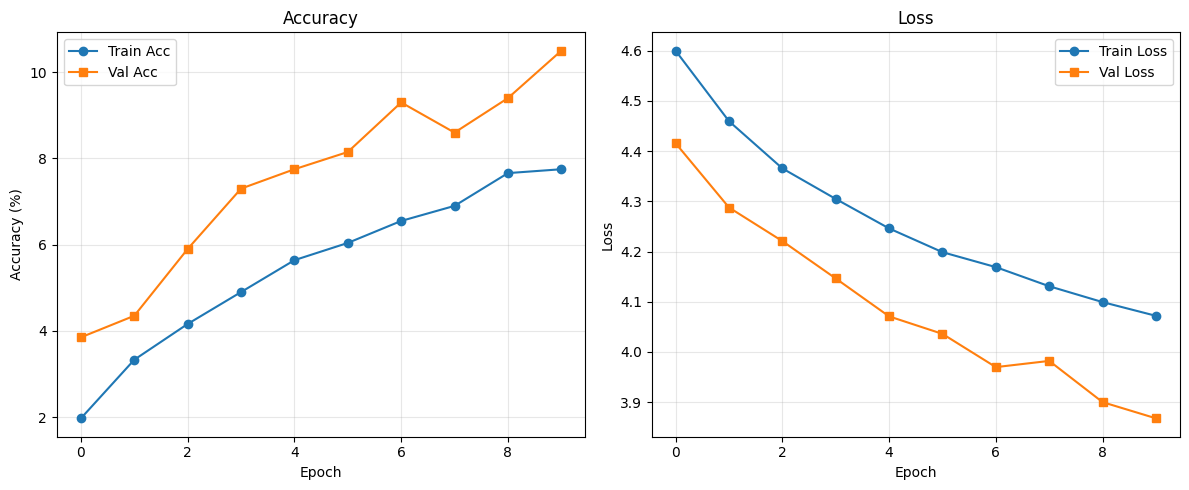

In [13]:
plt.figure(figsize=(12,5))
plt.subplot(1,2,1)
plt.plot(history['train_acc'], marker='o', label='Train Acc')
plt.plot(history['val_acc'], marker='s', label='Val Acc')
plt.title('Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')
plt.legend()
plt.grid(alpha=0.3)

plt.subplot(1,2,2)
plt.plot(history['train_loss'], marker='o', label='Train Loss')
plt.plot(history['val_loss'], marker='s', label='Val Loss')
plt.title('Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(alpha=0.3)

plt.tight_layout()
plt.show()